In [10]:
import glob
import matplotlib.pyplot as plt
import IPython
import tensorflow as tf
import seaborn as sns
import numpy as np
import pydub
import wave
import math

from pydub.playback import play
from scipy.io import wavfile

tf.InteractiveSession()

In [2]:
audio_files = glob.glob("../data/raw/positives/*/*")
audio_file = "../data/raw/test.wav"
IPython.display.Audio(audio_file)

In [3]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

def graph_spectrogram(wav_file, nfft=512, fs=2, noverlap=256):
    """
    Calculate and plot spectrogram for a wav audio file
    :param wav_file:
    :param nfft: Length of each window segment
    :param fs: Sampling frequencies
    :param noverlap: Overlap between windows
    :return:
    """
    rate, data = get_wav_info(wav_file)
    nchannels = data.ndim

    if nchannels > 1:
        data = data[:, 0]

    pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap=noverlap)

    return pxx

array([[1.22097489e+03, 3.22464760e+05, 1.85638673e+06, ...,
        2.18270913e+06, 4.04954117e+06, 1.19049536e+07],
       [1.59023095e+02, 8.64466748e+05, 8.34214422e+06, ...,
        2.64009836e+07, 3.13221342e+08, 4.19317850e+08],
       [5.12766633e+03, 4.02054367e+05, 7.71313965e+06, ...,
        9.12061237e+08, 1.52431187e+09, 2.09512325e+09],
       ...,
       [1.80263494e-01, 1.98289536e-02, 4.81944399e-01, ...,
        4.44441218e-01, 3.07044067e-01, 6.04364854e-01],
       [1.48715854e-01, 2.63539724e-01, 2.37015780e-01, ...,
        1.51266681e+00, 3.15568636e-02, 6.55478962e-01],
       [9.54800655e-02, 3.29988014e-01, 6.82147330e-02, ...,
        8.50287905e-01, 2.95763251e-02, 9.50815431e-03]])

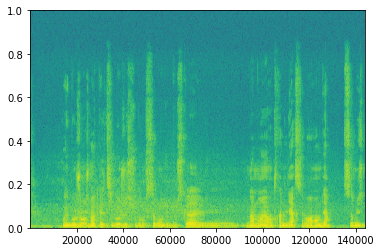

In [5]:
graph_spectrogram(audio_file)

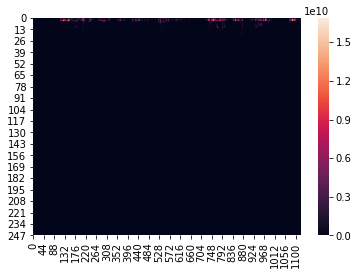

In [6]:
sns.heatmap(graph_spectrogram(audio_file))

In [6]:
sampling_rate = 16000
audio_binary = tf.read_file("../data/raw/backgrounds/speeches.wav")
# tf.contrib.ffmpeg not supported on Windows, refer to issue
# https://github.com/tensorflow/tensorflow/issues/8271
waveform = tf.contrib.ffmpeg.decode_audio(audio_binary, file_format='wav', samples_per_second=sampling_rate, channel_count=1)

W0819 11:03:08.597932 140734815663552 deprecation.py:323] From <ipython-input-6-17aab4dc7d6b>:5: decode_audio (from tensorflow.contrib.ffmpeg.ffmpeg_ops) is deprecated and will be removed after 2018-09-04.
Instructions for updating:
tf.contrib.ffmpeg will be removed in 2.0, the support for video and audio will continue to be provided in tensorflow-io: https://github.com/tensorflow/io


In [61]:
signals = tf.reshape(waveform, [1, -1])
stfts = tf.contrib.signal.stft(signals, 
                               frame_length=1024, 
                               frame_step=512,
                               fft_length=1024)
magnitude_spectrograms = tf.abs(stfts)

num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 128

linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sampling_rate, lower_edge_hertz,
    upper_edge_hertz)

mel_spectrograms = tf.tensordot(
    magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

log_offset = 1e-6
log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

num_mfccs = 20
# Keep the first `num_mfccs` MFCCs.
mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :num_mfccs]

print("waveform" , waveform.eval().shape)
print("signals" , signals.eval().shape)
print("magnitude_spectrograms" , magnitude_spectrograms.eval().shape)
print("mel_spectrograms" , mel_spectrograms.eval().shape)
print("log_mel_spectrograms" , log_mel_spectrograms.eval().shape)
print("mfccs" , mfccs.eval().shape)

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x14ae2cc50>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


waveform (95915, 1)
signals (1, 95915)
magnitude_spectrograms (1, 186, 513)
mel_spectrograms (1, 186, 128)
log_mel_spectrograms (1, 186, 128)
mfccs (1, 186, 20)


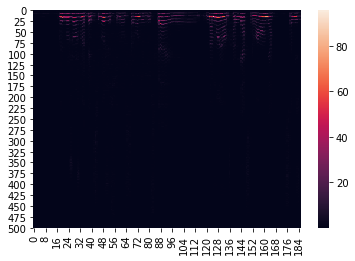

In [10]:
sns.heatmap(np.swapaxes(magnitude_spectrograms.eval()[0],0,1))

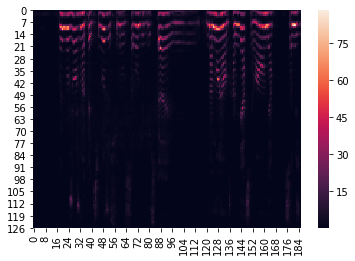

In [25]:
sns.heatmap(np.swapaxes(mel_spectrograms.eval()[0],0,1))

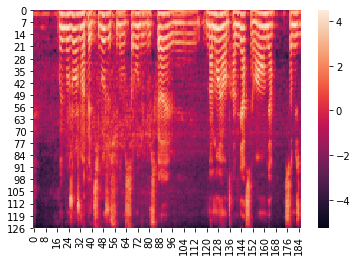

In [26]:
sns.heatmap(np.swapaxes(log_mel_spectrograms.eval()[0],0,1))

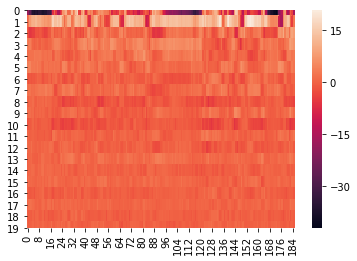

In [28]:
sns.heatmap(np.swapaxes(mfccs.eval()[0],0,1))

In [5]:
test = tf.read_file("test.wav")
test = tf.contrib.ffmpeg.decode_audio(test, file_format='wav', samples_per_second=sampling_rate, channel_count=1)

positive = tf.read_file(audio_file)
positive = tf.contrib.ffmpeg.decode_audio(positive, file_format='wav', samples_per_second=sampling_rate, channel_count=1)

NameError: name 'sampling_rate' is not defined

In [86]:
positive_audiosegment = pydub.AudioSegment(positive.eval().tobytes(), 
                                           frame_rate=sampling_rate, channels=1, 
                                           sample_width=positive.eval().dtype.itemsize)

In [70]:
test_audiosegment = pydub.AudioSegment(test.eval(),
                                       frame_rate=sampling_rate, channels=1,
                                       sample_width=test.eval().dtype.itemsize)

In [88]:
play(positive_audiosegment)

In [ ]:
play(test_audiosegment)

In [5]:
tf.InteractiveSession()

In [355]:
def get_dBFS(sound_array):
    sound_array_int = np.frombuffer(sound_array.tobytes(),dtype=np.int32)
    sound_array_rms = math.sqrt(np.sum(np.square(positive_int.astype(np.int64))/ positive_int.shape[0]))
    bits = sound_array_int.dtype.itemsize * 8
    max_possible_amplitude = (2 ** bits) / 2
    ratio = positive_rms / max_possible_amplitude
    dBFS = 20 * math.log(ratio, 10)
    return dBFS

In [360]:
def match_target_amplitude(sound, target_dBFS):
    """
    Used to standardize volume of audio clip
    :param sound: sound to standardize in numpy array from tensor
    :param target_dBFS: targeted volume
    :return: standardized sound
    """
    change_in_dBFS = target_dBFS - get_dBFS(sound)
    return sound * 10 ** (change_in_dBFS / 20)

array([[ 0.00134325],
       [ 0.00123946],
       [ 0.00105628],
       ...,
       [-0.0004274 ],
       [-0.00042129],
       [-0.00026865]], dtype=float32)

In [1]:
changed_positive = match_target_amplitude(positive.eval(), -20)
pydub.AudioSegment(changed_positive.tobytes(), frame_rate=16000, channels=1, sample_width=changed_positive.dtype.itemsize)


NameError: name 'match_target_amplitude' is not defined

In [354]:
10 ** (db / 20)

-6.023432162407067

In [335]:
np.array(positive_audiosegment.get_array_of_samples())

array([-1002245056, -1478065180,  1336267684, ...,   708915776,
        1301358992,  1677845504], dtype=int32)

In [258]:
positive_int = np.frombuffer(positive.eval().tobytes(),dtype=np.int32)
positive_rms = math.sqrt(np.sum(np.square(positive_int).astype(np.uint64)) / positive_int.shape[0])
bits = positive_int.dtype.itemsize
max_possible_amplitude = (2 ** bits) / 2
ratio = positive_rms/max_possible_amplitude
positive_dBFS = 20 * math.log(ratio, 10)

In [227]:
random_start = np.random.randint(low=0, high=test.eval().shape[0] - positive.eval().shape[0])
random_end = test.eval().shape[0] - positive.eval().shape[0] - random_start
padded_positive = np.pad(positive.eval(), ((random_start,random_end), (0,0)))
positive.eval().shape, test.eval().shape, padded_positive.shape

((11776, 1), (95915, 1), (95915, 1))

In [261]:
positive_int

array([ 1004274104,  1003159958,  1001193818, ..., -1156841192,
       -1156972268, -1162870432], dtype=int32)

In [267]:
test

In [259]:
positive_rms

39578647.85940018

In [266]:
test = pydub.AudioSegment(positive.eval().tobytes(), frame_rate=16000, channels=1, sample_width=positive.eval().dtype.itemsize)

test.rms, test.max_possible_amplitude, test.rms / test.max_possible_amplitude


(1073391761, 2147483648.0, 0.4998369892127812)

In [115]:
sound = test.eval() + np.pad(positive.eval(), ((random_start,random_end), (0,0))) * 10

In [116]:
play(pydub.AudioSegment(sound.tobytes(), frame_rate=16000, channels=1, sample_width=sound.dtype.itemsize))

In [113]:
IPython.display.Audio(audio_files[3])